전체 pass@1은 0.6285이다.
414가지 문제에 대해 그룹화하여 문제별 pass@1 의 평균은 0.6614 이다. 표준편차는 0.234으로 문제 간 차이가 큰 것을 알 수 있다.

최대 통과 비율은 0.969 최소는 0.011이며 세 구간으로 구분하면 다음과 같다.

| 패스 비율 구간         | 문제 수  | 평균 패스 비율 | 구간 비율 |
| ---------------- | ----- | -------- |---------
| Low (<30 %)      | 46 개  | 0.195    | 0.11 |
| Medium (30–70 %) | 135 개 | 0.527    | 0.33 |
| High (>70 %)     | 233 개 | 0.831    | 0.56 |

56%의 문제 유형에 대해 평균 패스 비율 83%를 달성했다는 결과를 얻을 수 있었다. 

하지만 코드 유사도에서는 
* AST 유사도 0.5
* Line 유사도 0.13  

으로 AI 모델의 1차적인 목표인 알고리즘 문제 제출 코드의 논리적 오류를 수정해주는 것은 어느정도 성공적이지만, 알고리즘 풀이 코드의 **논리적 오류만을 수정**해주는 AI 모델이라고 하기에는 다소 무리가 있다.

## 필요한 패키지 및 데이터 로드

In [24]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from collections import defaultdict
from scipy.stats import pearsonr

# 경고 무시
import warnings
warnings.filterwarnings('ignore')

In [42]:
# task_detail.json 로드
with open("base_task_set/task_detail.json", "r", encoding="utf-8") as f:
    task_info = json.load(f)

In [66]:
# 채점 데이터 로드
with open("result.json", "r", encoding="utf-8") as f:
    data = json.load(f)

## 문제별 통계 함수 정의

```python
def aggregate_problem_stats(data):
    ...
```

문제(`p_name`) 단위로 **성공/실패 및 오류 유형 통계**를 집계하고 비율 형태로 정리된 리스트를 반환

### 출력

* 문제별 통계를 정리한 딕셔너리 리스트 (list of dict)

| 필드명                         | 의미                     | 예시 (값)     |
| ----------------------------- | ---------------------- | ---------- |
| `p_name`                      | 문제 ID                  | `"p02664"` |
| `p_score`                     | 문제 점수                | `200` |
| `p_desc_len`                  | 문제 길이                | `243` |
| `total`                       | 해당 문제의 총 fixed code 수    | `1275`       |
| `pass`                        | 해당 문제를 통과한 fixed code 수   | `1200`       |
| `fail`                        | 해당 문제를 실패한 fixed code 수   | `75`       |
| `Runtime Error`               | 실패 중 런타임 오류 개수         | `50`       |
| `Wrong Answer`                | 실패 중 오답 개수       | `15`       |
| `Timeout`                     | 실패 중 시간 초과 개수       | `10`       |
| `Other Error`                 | 실패 중 기타 오류 개수       | `0`       |
| `pass_rate`                   | 성공 비율 (`pass / total`) | `0.35`     |
| `fail_rate`                   | 실패 비율 (`fail / total`) | `0.65`     |
| `runtime_error_ratio_in_fail` | 실패 중 런타임 오류 비율         | `0.20`     |
| `timeout_ratio_in_fail`       | 실패 중 시간 초과 비율          | `0.10`     |
| `wrong_answer_ratio_in_fail`  | 실패 중 오답 비율             | `0.65`     |
| `other_error_ratio_in_fail`   | 실패 중 기타 오류 비율          | `0.05`     |

실패했을 때 어떤 유형의 오류가 주로 발생했는지를 파악할 수 있도록 `~_in_rate`의 항목들을 추가하였다.

### 오류 유형 분류 방식

* 각 실패 샘플에 대해 **우선순위 기반 오류 분류**를 수행함
  `Runtime Error > Timeout > Wrong Answer > Other Error` 중 하나로 단일 분류

#### 우선순위 기반 오류 분류 이유

실패 한 건에 여러 오류 유형이 존재할 수 있지만, 실제로는 **하나의 핵심 실패 원인**이 문제 해결을 막는 경우가 대부분이며  
이때 다음과 같은 이유로 우선순위 기반 단일 분류가 효과적이라고 판단했다.

* **불필요한 중복 제거**: 동일한 실패에 대해 여러 오류를 중복 카운트하면 비율 해석이 왜곡됨
* **해석의 일관성 유지**: 오류 비율 합이 항상 1이 되므로 비교와 시각화가 직관적
* **실제 디버깅 우선순위와 일치**: 일반적으로 `Runtime Error` → `Timeout` → `Wrong Answer` 순으로 문제를 해결해야 하는 실제 디버깅 흐름과도 일치

이 방식을 통해 오류 경향성을 통계적으로 안정적으로 분석할 수 있다.

In [5]:
def map_error_reason(reason):
    """오류 유형 매핑 함수"""
    if reason.startswith("[ERROR] Timeout"):
        return "Timeout"
    elif reason.startswith("[ERROR] Runtime Error"):
        return "Runtime Error"
    elif reason.startswith("Wrong Answer"):
        return "Wrong Answer"
    else:
        return "Other Error"

def get_priority_error(reasons):
    """
    하나의 실패 샘플에 대해 우선순위 기반으로 대표 오류 분류
    """
    reason_set = set(map(map_error_reason, reasons))
    if "Runtime Error" in reason_set:
        return "Runtime Error"
    elif "Timeout" in reason_set:
        return "Timeout"
    elif "Wrong Answer" in reason_set:
        return "Wrong Answer"
    else:
        return "Other Error"

In [ ]:
def aggregate_problem_stats(inner_data):
    """
    문제 단위로 집계하여 통계 딕셔너리로 변환
    """
    # 통계 초기화
    stats = defaultdict(lambda: {
        "total": 0,
        "pass": 0,
        "fail": 0,
        "Runtime Error": 0,
        "Wrong Answer": 0,
        "Timeout": 0,
        "Other Error": 0
    })

    # 통계 누적
    for item in inner_data:
        p = item["p_name"]
        stats[p]["total"] += 1

        if item["result"] == "pass":
            stats[p]["pass"] += 1
        else:
            stats[p]["fail"] += 1
            reasons = [f.get("reason", "") for f in item.get("failures", [])]
            major_error = get_priority_error(reasons)
            stats[p][major_error] += 1

    # 비율 계산
    records = []
    for p_name, s in stats.items():
        total = s["total"]
        fail = s["fail"]
        if total == 0:
            continue
        records.append({
            "p_name": p_name,
            "p_score": int(task_info[p_name]["score"]),
            "p_desc_len": len(task_info[p_name]["desc"]),
            **s,
            "pass_rate": s["pass"] / total,
            "fail_rate": fail / total,
            "runtime_error_ratio_in_fail": s["Runtime Error"] / fail if fail else 0,
            "timeout_ratio_in_fail": s["Timeout"] / fail if fail else 0,
            "wrong_answer_ratio_in_fail": s["Wrong Answer"] / fail if fail else 0,
            "other_error_ratio_in_fail": s["Other Error"] / fail if fail else 0
        })
    
    return pd.DataFrame(records)

In [68]:
def show_distribution_pass_rate_per_problem(df):
    plt.figure(figsize=(10, 6))
    sns.histplot(df["pass_rate"], bins=np.arange(0, 1.0001, 0.02), kde=True, color="skyblue")

    plt.title("Distribution of Pass Rate per Problem")
    plt.xlabel("Pass Rate")
    plt.ylabel("Number of Problems")
    plt.axvline(0.7, color='orange', linestyle='--', label='pass_rate = 0.7')
    plt.axvline(0.3, color='red', linestyle='--', label='pass_rate = 0.3')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## pass@1 한번에 올바른 수정이 이루어졌는지 판단

전체 pass@1은 0.6285이다.
414가지 문제에 대해 그룹화하여 문제별 pass@1 의 평균은 0.6614 이다. 표준편차는 0.234으로 문제 간 차이가 큰 것을 알 수 있다.

최대 통과 비율은 0.969 최소는 0.011이며 세 구간으로 구분하면 다음과 같다.

| 패스 비율 구간         | 문제 수  | 평균 패스 비율 | 구간 비율 |
| ---------------- | ----- | -------- |---------
| Low (<30 %)      | 46 개  | 0.195    | 0.11 |
| Medium (30–70 %) | 135 개 | 0.527    | 0.33 |
| High (>70 %)     | 233 개 | 0.831    | 0.56 |

In [74]:
print(df["pass"].sum()/df["total"].sum(), df["pass_rate"].mean(), df['pass_rate'].std())

0.6285010475747986 0.6614323563579099 0.2337803594882924


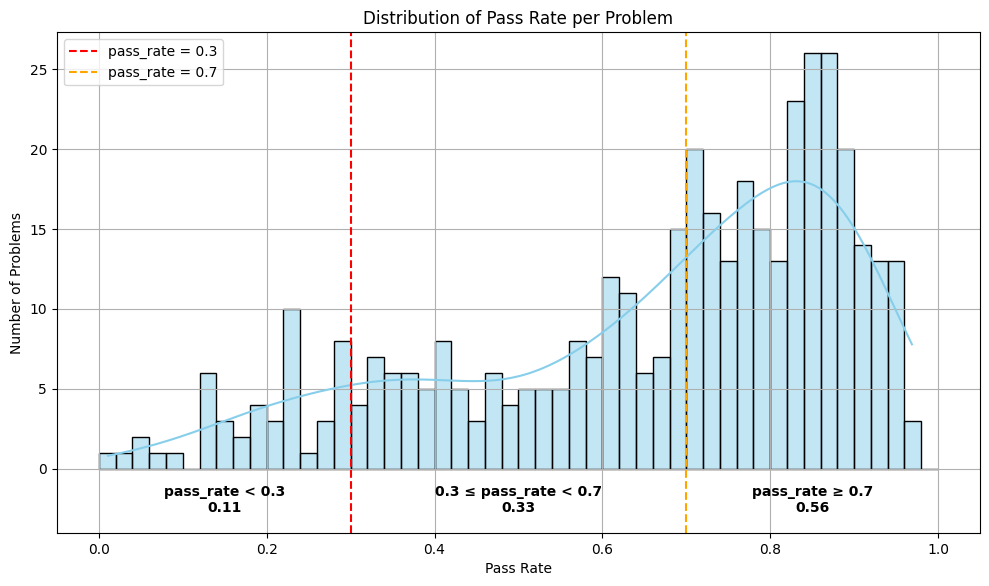

In [77]:
def show_distribution_pass_rate_per_problem_group(df):
    # 구간 정의: (시작, 끝), 색상, 범례용 이름
    plt.figure(figsize=(10, 6))
    regions = [
        ((0.0, 0.3), 'pass_rate < 0.3'),
        ((0.3, 0.7), '0.3 ≤ pass_rate < 0.7'),
        ((0.7, 1.0), 'pass_rate ≥ 0.7'),
    ]

    sns.histplot(df["pass_rate"], bins=np.arange(0, 1.0001, 0.02), kde=True, color="skyblue")

    # 구간 기준선
    plt.axvline(0.3, color='red', linestyle='--', label='pass_rate = 0.3')
    plt.axvline(0.7, color='orange', linestyle='--', label='pass_rate = 0.7')

    # 구간별 텍스트 아래 표시
    for (start, end), label in regions:
        setion = df.query(f"{start} <= pass_rate < {end}")
        # print(setion["pass_rate"].mean())
        plt.text((start + end) / 2, -1, f"{label}\n{setion.shape[0]/df.shape[0]:.2f}",
                 ha='center', va='top', fontsize=10, fontweight='bold')

    plt.title("Distribution of Pass Rate per Problem")
    plt.xlabel("Pass Rate")
    plt.ylabel("Number of Problems")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.ylim(bottom=-4)  # 아래 텍스트 공간 확보
    plt.show()
show_distribution_pass_rate_per_problem_group(df)

### 문제 난이도와 패스 비율

문제 난이도와 패스 비율의 관계를 분석해보았다.  
score와 패스 비율 사이에 `−0.614`의 음의 상관관계가 나타나, 점수가 높아질수록 패스 비율이 낮았다.

100점 문제의 평균 패스 비율이 0.82로 가장 높고, 200점 문제는 0.65, 300점 문제는 0.45까지 떨어진다.

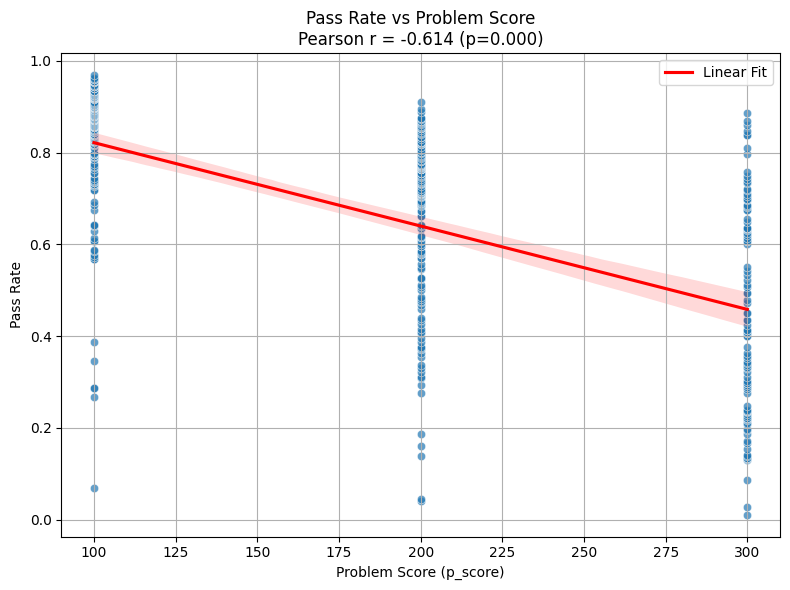

In [78]:
def analyze_pass_rate_vs_score(df):
    corr, p_value = pearsonr(df['pass_rate'], df['p_score'])
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='p_score', y='pass_rate', data=df, alpha=0.7)
    sns.regplot(x='p_score', y='pass_rate', data=df, scatter=False, color='red', label='Linear Fit')

    plt.title(f"Pass Rate vs Problem Score\nPearson r = {corr:.3f} (p={p_value:.3f})")
    plt.xlabel("Problem Score (p_score)")
    plt.ylabel("Pass Rate")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
analyze_pass_rate_vs_score(df)

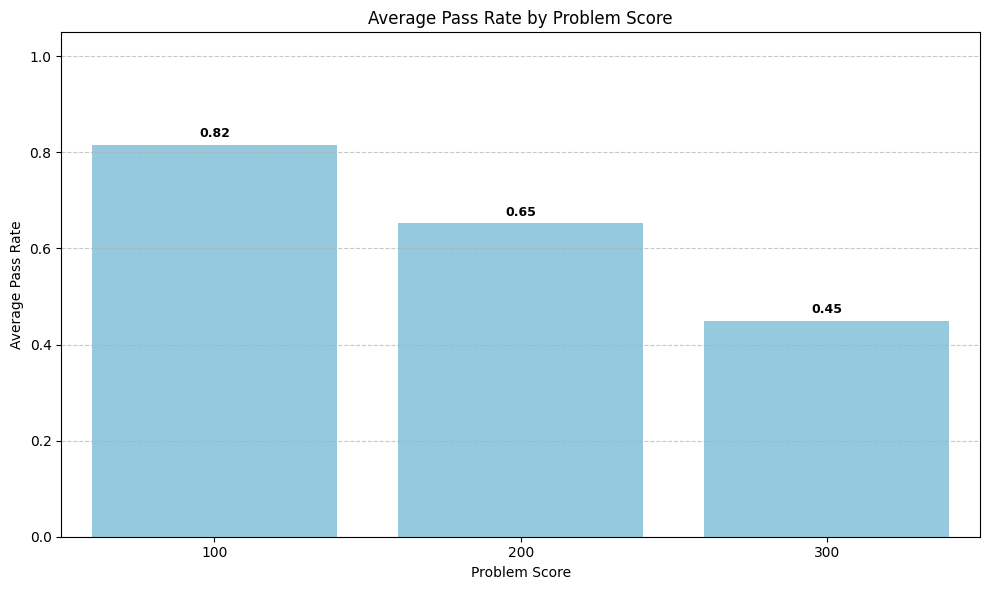

In [79]:
def plot_avg_pass_rate_with_labels(df):
    # 점수별 평균 pass_rate 계산
    grouped = df.groupby("p_score")["pass_rate"].mean().reset_index()

    plt.figure(figsize=(10, 6))
    ax = sns.barplot(data=grouped, x="p_score", y="pass_rate", color="skyblue")

    # 막대 위에 평균값 표시 (소수점 2자리)
    for idx, row in grouped.iterrows():
        ax.text(
            x=idx,
            y=row["pass_rate"] + 0.01,  # 막대 위에 약간 띄움
            s=f"{row['pass_rate']:.2f}",
            ha='center',
            va='bottom',
            fontsize=9,
            fontweight='bold'
        )

    plt.title("Average Pass Rate by Problem Score")
    plt.xlabel("Problem Score")
    plt.ylabel("Average Pass Rate")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
plot_avg_pass_rate_with_labels(df)

### 문제 길이와 패스 비율

문제 길이와 패스 비율의 관계를 분석해보았다.  
설명 길이와 패스 비율 사이의 상관계수는 –0.31로, 설명이 길수록 패스 비율이 낮은 경향이 관찰된다.  
이는 문제 설명이 길다는 것은 입력·출력 조건과 예외 케이스가 많거나 어렵다는 것을 의미하며, AI 모델이 이런 문제를 어려워한다는 증거이다.

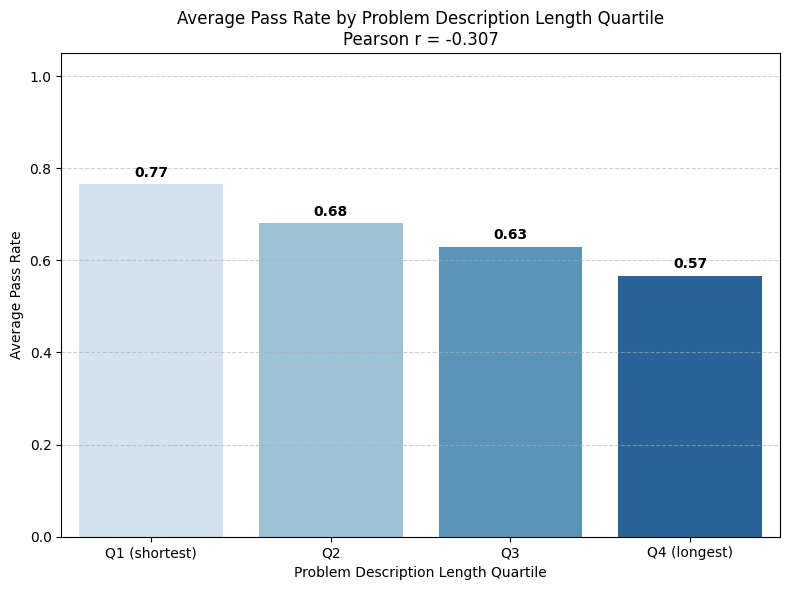

In [81]:
def plot_pass_rate_by_desc_length_quartile(df):
    # 1. Pearson 상관계수 계산
    corr = df[['p_desc_len', 'pass_rate']].corr().iloc[0, 1]

    # 2. 설명 길이를 사분위로 나눔
    df["desc_len_quartile"] = pd.qcut(df["p_desc_len"], q=4, labels=["Q1 (shortest)", "Q2", "Q3", "Q4 (longest)"])

    # 3. 각 사분위의 평균 pass_rate 계산
    grouped = df.groupby("desc_len_quartile")["pass_rate"].mean().reset_index()

    # 4. 시각화
    plt.figure(figsize=(8, 6))
    ax = sns.barplot(data=grouped, x="desc_len_quartile", y="pass_rate", palette="Blues")

    # 5. 막대 위에 평균값 표시
    for idx, row in grouped.iterrows():
        ax.text(
            idx,
            row["pass_rate"] + 0.01,
            f"{row['pass_rate']:.2f}",
            ha='center',
            va='bottom',
            fontsize=10,
            fontweight='bold'
        )

    plt.title(f"Average Pass Rate by Problem Description Length Quartile\nPearson r = {corr:.3f}")
    plt.xlabel("Problem Description Length Quartile")
    plt.ylabel("Average Pass Rate")
    plt.ylim(0, 1.05)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
plot_pass_rate_by_desc_length_quartile(df)

## 실패한 문제 분석

전체 fail 중 각 에러 비중은
* Runtime Error: 0.6035
* Wrong Answer: 0.3461
* Timeout: 0.0502

즉, 제출 코드가 실패하는 가장 큰 원인은 런타임 예외(예: 인덱스 에러, import 에러 등)이며, 알고리즘적 오답과 성능 부족으로 인한 타임아웃은 그 다음이다.

| 패스 비율 구간         | 평균 Runtime Error 비율 | 평균 Wrong Answer 비율 | 평균 Timeout 비율 |
| ---------------- | ------------------- | ------------------ | ------------- |
| Low (<30 %)      | 0.699               | 0.2647              | 0.054         |
| Medium (30–70 %) | 0.564               | 0.383              | 0.052         |
| High (>70 %)     | 0.512               | 0.441              | 0.047         |

패스 비율이 낮은 문제일수록 런타임 오류 비중이 높고 오답 비중이 낮다. 반대로 쉽게 통과되는 문제에서는 런타임 오류보다 오답이 더 큰 실패 요인이다.

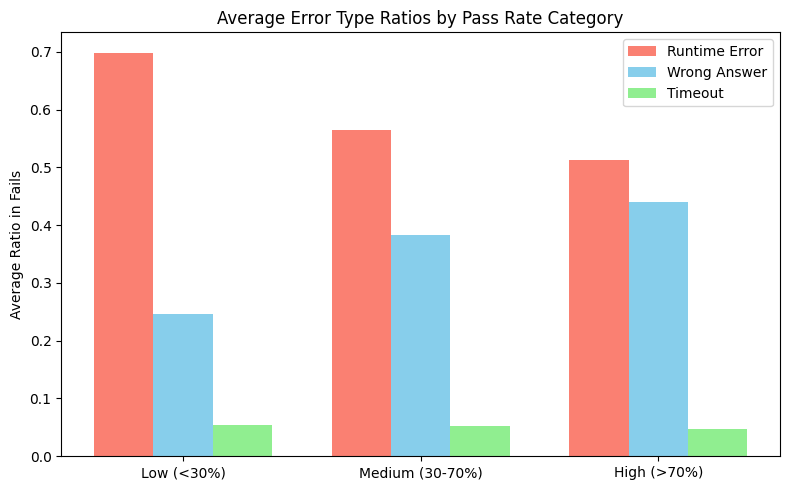

In [85]:
def plot_error_ratios_by_pass_rate_category(df):
    # 1. pass_rate 구간 나누기
    bins = [0.0, 0.3, 0.7, 1.0]
    labels = ['Low (<30%)', 'Medium (30-70%)', 'High (>70%)']
    df['pass_rate_group'] = pd.cut(df['pass_rate'], bins=bins, labels=labels, right=False)

    # 2. 그룹별 평균 오류 비율 계산
    grouped = df.groupby('pass_rate_group')[
        ['runtime_error_ratio_in_fail', 'wrong_answer_ratio_in_fail', 'timeout_ratio_in_fail']
    ].mean()

    # 3. 시각화
    x = np.arange(len(grouped.index))  # 그룹 수
    width = 0.25

    fig, ax = plt.subplots(figsize=(8, 5))

    ax.bar(x - width, grouped['runtime_error_ratio_in_fail'], width, label='Runtime Error', color='salmon')
    ax.bar(x, grouped['wrong_answer_ratio_in_fail'], width, label='Wrong Answer', color='skyblue')
    ax.bar(x + width, grouped['timeout_ratio_in_fail'], width, label='Timeout', color='lightgreen')

    ax.set_xticks(x)
    ax.set_xticklabels(grouped.index)
    ax.set_ylabel("Average Ratio in Fails")
    ax.set_title("Average Error Type Ratios by Pass Rate Category")
    ax.legend()
    plt.tight_layout()
    plt.show()
plot_error_ratios_by_pass_rate_category(df)

### 코드 샘플링

통과율이 0.3 이하인 문제들을 몇가지 확인해보고 원인들을 파악해보았다.

In [119]:
df_lower_30 = df[df["pass_rate"] <= 0.3].sort_values(by="wrong_answer_ratio_in_fail", ascending=True)
df_lower_30[["p_name", "p_score", "pass_rate", "runtime_error_ratio_in_fail", "wrong_answer_ratio_in_fail"]]

,p_name,p_score,pass_rate,runtime_error_ratio_in_fail,wrong_answer_ratio_in_fail
377,p03721,300,0.229981,0.972189,0.027811
74,p03030,200,0.044153,0.935081,0.042447
201,p02646,200,0.138106,0.937081,0.049077
370,p03434,200,0.186147,0.946809,0.053191
148,p03262,300,0.010909,0.896140,0.058824
193,p03767,300,0.275766,0.905769,0.059615
51,p02995,300,0.140895,0.920459,0.061911
34,p02777,100,0.287846,0.928144,0.065868
208,p02761,300,0.085500,0.915314,0.072786
143,p03400,200,0.041026,0.909091,0.090909


In [ ]:
def print_p_desc(p_name:str):
    info = task_info.get(p_name, {})
    print("=" * 100)
    print(f"🟦 문제 ID: {p_name} 난이도: {info.get('score', 0)}")
    print(f"📌 제목: {info.get('title', '')}")
    print(f"📋 설명: {info.get('desc', '').strip()}")
    print(f"🧩 입력 설명: {info.get('input_desc', '')}")
    print(f"🧾 출력 설명: {info.get('output_desc', '')}")
    print("-" * 80)
def print_fail_detail(p_name:str, head:int = 5):
    filtered_failures = [d for d in data if d["p_name"] == p_name and d["result"] == "fail"]
    if len(filtered_failures) == 0:
        print("잘못된 문제")
        return
    print_p_desc(p_name)
    for d in filtered_failures[:head]:
        print(f"❌ 실패 이유: {[str(f) for f in d.get('failures', [])]}")
        print("-" * 80)
        print("🧪 Source (오답 코드):")
        print(d.get("source", "").strip())
        print("-" * 80)
        print("🤖 Pred (모델 생성 코드):")
        print(d.get("pred", "").strip())
        print("-" * 80)
        print("✅ Target (정답 코드):")
        print(d.get("target", "").strip())
        print("=" * 100 + "\n")

### 추상화 오류
#### p02391

```python
var0, var1 = map(int, input().split(' '))
if var0 < var1:
	print('var0', '<', 'var1')
elif var0 > var1:
	print('var0', '>', 'var1')
else:
	print('var0', '==', 'var1')
```

추상화 과정에서 출력 형식에 맞게 출력해야하는 문자열이 의도치않게 추상화되어버렸다.

#### p03721

pass_rate: 0.229981  
runtime_error_ratio_in_fail: 0.972189  를 달성한 문제이다.

**입력값 파싱 실패**  
```python
var0 = var1 = map(int, input().split())
var2 = [list(map(int, input().split())) for _ in range(var0)]
var3 = 0
var2.sort()
for i in range(var0):
	var3 += var2[i][1]
	if var3 >= var1:
		print(var2[i][0])
		break
```
**`sys.stdin.buffer.readline` 추상화 오류**  
```python
import sys
var0 = sys.stdin.buffer.var0
var1 = sys.stdin.buffer.var1
var2 = sys.stdin.buffer.var2
var3 = 10 ** 5
var8 = 10 ** 5
var9 = map(int, var1().split())
var10 = 0
for i in range(var3):
	var10 += var9[i][1]
	if var10 >= var8:
		print(var9[i][0])
		exit()
```

주로 비정상적으로 실패중 런타임 오류가 많은 문제는 학습 데이터의 추상화가 잘못되어 모델 자체가 잘못 학습됐다고 판단할 수 있다.

### 오래된 문법 및 학습 데이터 부족
#### p02853

난이도가 낮은 문제지만 낮은 통과율과 높은 wrong answer 비율을 달성했다.   
해당 문제에 대한 학습 데이터가 부족했으며 파이썬 2버전에서 사용되던 `raw_input()`을 사용하는 것으로 확인되어 런타임 오류가 많이 발생했던것으로 판단된다.

## 코드 변화량 분석

테스크 케이스를 통과한 pred(fixed code)와 source(bugy code)를 비교해볼것이다.  
source(bugy code) 에서 정답코드로 수정되었다고 해도 기존 오류 코드에서 논리적 오류가 수정된 것인지, 단순히 학습된 정답코드를 생성한 것인지를 판단할 수 있다.

### 통계 함수 정의

#### 라인 변화 비율 함수

두 코드 간의 줄(Line) 단위 유사도를 계산하는 함수

* 공백/빈 줄은 제외하고 실질적인 코드 라인만 비교

* 줄 단위 삽입/삭제/수정을 고려하여 얼마나 유사한지를 0.0 ~ 1.0 사이의 실수로 반환한다.

    * 1.0에 가까울수록 변경이 적고,

    * 0.0에 가까울수록 대부분의 줄이 수정됨을 의미한다.

In [ ]:
import difflib

def compute_line_edit_ratio(code_before: str, code_after: str) -> int:
    """
    두 코드 간의 줄 단위 변경 비율을 계산합니다.
    공백/빈 줄은 무시하며, 삽입/삭제/수정된 줄 수를 기반으로 비교합니다.
    반환값은 유사도(1.0에 가까울수록 유사)입니다.
    """
    def clean_lines(code: str):
        return [line for line in code.strip().splitlines() if line.strip() != ""]

    before_lines = clean_lines(code_before)
    after_lines = clean_lines(code_after)

    sm = difflib.SequenceMatcher(None, before_lines, after_lines)
    opcodes = sm.get_opcodes()

    changed_lines = 0
    for tag, i1, i2, j1, j2 in opcodes:
        if tag == "replace":
            changed_lines += max(i2 - i1, j2 - j1)  # 교체는 양쪽 최대 줄 수
        elif tag == "insert":
            changed_lines += j2 - j1  # after에 삽입된 줄 수
        elif tag == "delete":
            changed_lines += i2 - i1  # before에서 삭제된 줄 수

    base_line_count = max(len(before_lines), 1)  # 0줄 대비 방지
    ratio = min(changed_lines / base_line_count, 1.0)
    return round(1 - ratio, 4)

### 추상구문트리 변화 비율 함수

[CodeBleu - syntax_match.py](https://github.com/k4black/codebleu/blob/main/codebleu/syntax_match.py) 의 함수를 그대로 사용하였다.

AST (Abstract Syntax Tree)를 이용하여 두 코드의 구조적 유사도를 정량적으로 측정한다.

* 각 코드 쌍에 대해 매칭하는 AST 노드 비율을 계산한다.

* 전체 트리에서 공통 노드의 비율이 많을수록 유사도 수치가 높게 산출된다.

### 결과

우선적으로 결과는 아래와 같이 나왔다.

**ASTNodeDiff mean: 0.50**

**LineDiff mean: 0.13**

각 수치에 대한 해석과 그 의미를 해석해보자면

#### ASTNodeDiff (0.50)

* **의미:** AST(Abstract Syntax Tree) 기반 구조적 유사도는 중간 정도 수준(50%)이다.
* **해석:** 동일한 문제 풀이에 대해 전체적인 구조(함수 구조, 반복문, 조건문 등)는 유사하게 유지되었기 때문에 ASTNodeDiff가 0으로 수렴하지는 않았다.
* **시사점:** AI는 완전히 새로운 알고리즘을 작성하기보다는 기존 풀이 구조를 기반으로 수정 작업을 수행한 것으로 보인다.

#### LineDiff (0.13)

* **의미:** 수정 전후 코드 간 라인 단위 유사도는 매우 낮다.(13% 유사).
* **해석:**
  * LineDiff는 문법적 구조보다 코드의 물리적 줄 위치, 순서, 변수 선언 위치 등에 민감하다.
  * 같은 로직이라도 포맷, 순서 변경에 의해 큰 차이로 측정된다.
* **시사점:** AI가 단순히 기존 코드에서 버그만 수정한 것이 아니라, **사실상 새로운 코드**를 작성했다고 해석할 수 있다.

#### 종합 해석

* **전체적으로**, AI는 주어진 버그 코드의 일부만 고친 것이 아니라, 문제의 정답을 새롭게 생성해낸 것으로 보인다.
* **특히 LineDiff가 0에 가까운 수치(0.13)**라는 점은 AI가 디버깅을 수행했다기보다는 **기존 문제에 대한 학습된 정답을 생성했을 가능성**이 높다.

## 결론
* 해당 AI 모델의 1차적인 목표인 알고리즘 문제 제출 코드의 논리적 오류를 수정해주는 것은 어느정도 성공적.
* 하지만 알고리즘 풀이 코드의 **논리적 오류만을 수정**해주는 AI 모델이라고 하기에는 다소 무리가 있다는 것이 나의 결론이다.
* 시간이 된다면 더 큰 모델이나 LLM 등을 활용하여 개선을 해보고 싶다.